# EJERCICIO 2 : DELFINES DE NUEVA ZELANDA

In [1]:
import numpy as np
import networkx as nx
import os
from random import shuffle          # importamos las librerias necesarias
import matplotlib.pylab as plt       
%matplotlib inline
from matplotlib.pyplot import title,xlabel,ylabel,show

In [2]:
G = nx.read_gml('dolphins.gml') # definimos la red:cada nodo es un delfin y cada conexion representa una interaccion

In [3]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

dolphinsGender=ldata('dolphinsGender.txt') # usamos la funcion "ldata" para abrir el archivo .txt 
                                           # que contiene el genero de cada delfin

In [4]:
dict_gender = {dolphin_nombre : genero for dolphin_nombre, genero  in dolphinsGender} #lista a diccionario

In [5]:
def AssignGender(G,dict_gender):
    for n in G.nodes:
        G.nodes[n]["gender"] = dict_gender[n]
    return

for n in G.nodes:                                   # usamos la funcion "AssignGender" para asignar
    G.nodes[n]["gender"] = dict_gender[n]           # un atributo (genero) a los nodos de la red (delfines)

In [6]:
list(nx.get_node_attributes(G,'gender').items())[0:9]  #chequeamos algunos casos

[('Beak', 'm'),
 ('Beescratch', 'm'),
 ('Bumper', 'm'),
 ('CCL', 'f'),
 ('Cross', 'm'),
 ('DN16', 'f'),
 ('DN21', 'm'),
 ('DN63', 'm'),
 ('Double', 'f')]

# (A) Examine diferentes opciones de layout para este grafo e identifique la que le resulte más informativa. Justifique su elección detallando las características estructurales de la red que su elección pone en evidencia. Incluya en la representación gráfica de la red información sobre el sexo de los delfines.

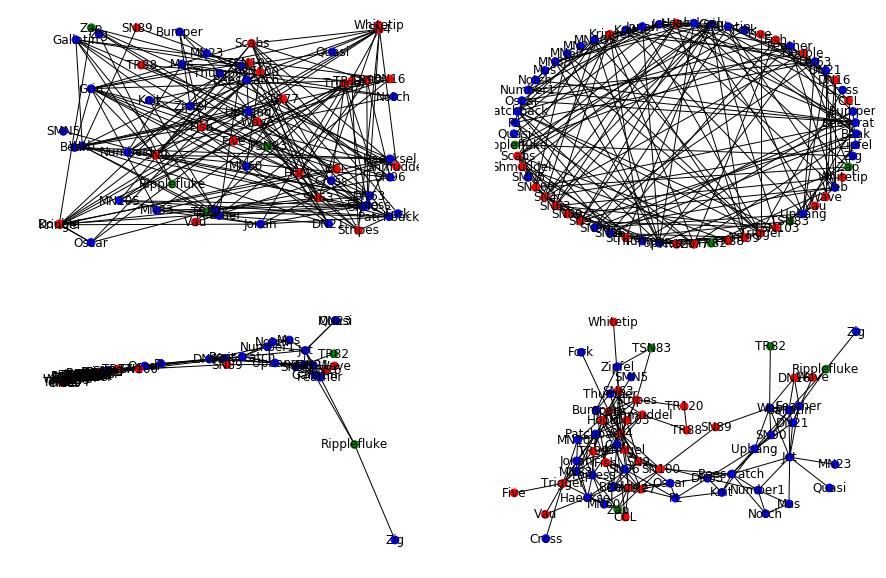

In [7]:
def color(g):                  
    if g=='m':
        col='blue'
    elif g=='f':                   # definimos una funcion para asignar un color distinto a cada genero
        col='red'
    else:
        col='green'
    return col

options = {'node_color':[color(g) for g in nx.get_node_attributes(G,'gender').values()],
           'node_size':60,'with_labels':True}

plt.figure(figsize=(15,10))
plt.subplot(221)
nx.draw_random(G, **options)
plt.subplot(222)
nx.draw_circular(G, **options)           # graficamos la red con distintos layouts
plt.subplot(223)
nx.draw_spectral(G, **options)
plt.subplot(224)
nx.draw_spring(G, **options)

De los distintos Layouts analizados, el método "Fruchterman-Reingold Force-Directed Graph"  es el que nos permite visualizar mejor la estructura de la red. (https://en.wikipedia.org/wiki/Force-directed_graph_drawing)

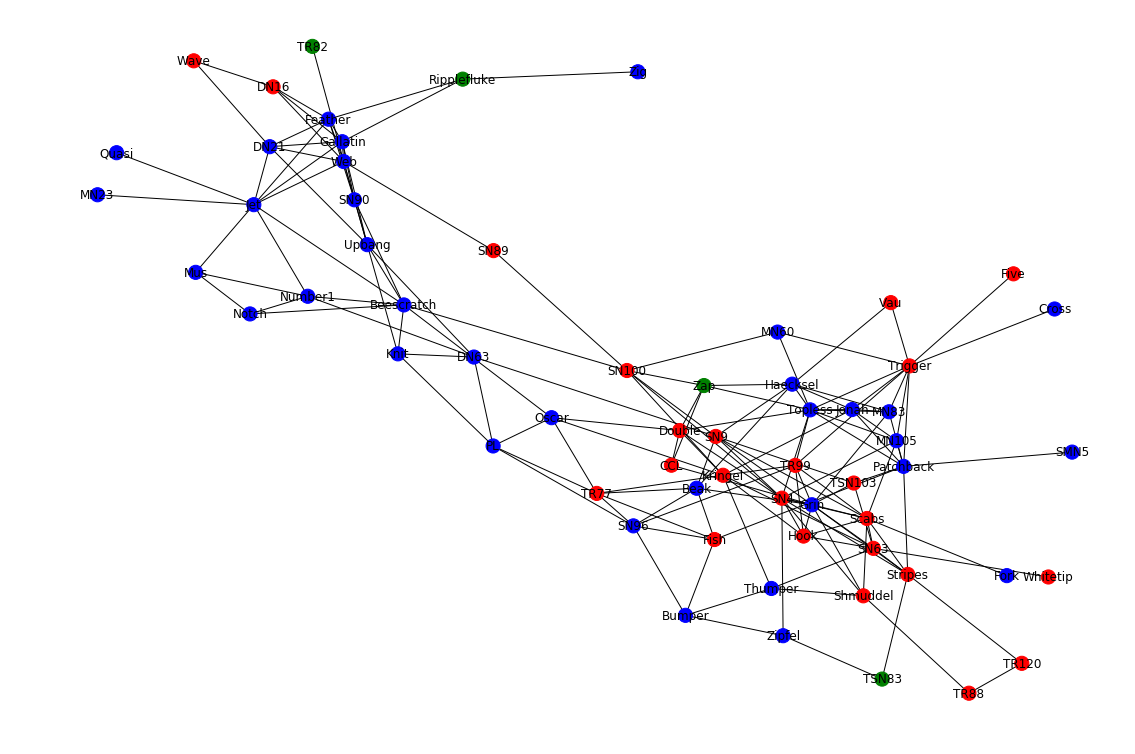

In [8]:
options = {'node_color':[color(g) for g in nx.get_node_attributes(G,'gender').values()],
           'node_size':200,'with_labels':True}

plt.figure(figsize=(15,10))
nx.draw_spring(G, **options)

# (B) ¿Se trata una red donde prevalece la homofilia en la variable género?

# (i) Considere la distribución nula para la fracción de enlaces que vinculan géneros diferentes, generada a partir de al menos 1000 asignaciones aleatorias de género.

La modularidad es una medida de la estructura de las redes. Particularmente mide la fuerza de la división de una red en módulos/comunidades. Las redes con alta modularidad tienen conexiones sólidas entre los nodos dentro de los módulos, pero escasas conexiones entre nodos en diferentes módulos, con lo cual resulta un parámetro óptimo para observar la presencia de homofilia en una red. La modularidad se defino como:

$$Q=\frac{1}{2m} \sum_{ij} \delta(c_{i}, c_{j}) (A_{ij}-\frac{k_{i}k_{j}}{2m})$$

<br>
$k_{i}:$ grado del nodo i 
<br>
$k_{j}:$ grado del nodo j
<br>
$c_{i}:$ clase i
<br>
$c_{j}:$ clase j
<br>
$m:$ cantidad de enlaces total 
<br>
$A_{ij} = 1$ si hay un enlace entre el nodo i y el nodo j 
<br>
$A_{ij} = 0$ en otro caso.
<br>

In [9]:
def delta(c_i, c_j):
    if  c_i == c_j:
        return 1 
    else:
        return 0 

#definimos la funcion modularidad a partir de un grafo 'G' que ya tiene montado el campo escalar 'FieldString' que
#le da una clase a cada nodo

def modularity(G,FieldString):
    modularity = 0
    m = np.shape(nx.edges(G))[0] #cantidad de enlaces
    A = nx.to_numpy_matrix(G)    #adjency matrix (por definicion cumple las condiciones de A_ij mencionadas arriba)
    
    Degree = list(G.degree)                     # lista de tuplas (nodo,grado) con un orden determinado
    degree = [degree for node,degree in Degree] # genero un vector donde cada elemento es el grado para el nodo
                                                # indexado como 0,1,2... , que se corresponde con el orden de 
                                                # la lista Degree
    
    atrributes = list(nx.get_node_attributes(G,FieldString).values())  #lista con los generos ordenados
    
    for i in range(np.size(nx.nodes(G))):
        for j in range(np.size(nx.nodes(G))):
            modularity = ((1/(2 * m)) * delta(atrributes[i], atrributes[j])*     # calculo la modularidad
                          (A[i,j] - (degree[i] * degree[j])/(2*m))+modularity)
    
    return modularity

In [10]:
modularity(G, 'gender') # modularidad de la red real

0.12370950516197912

Modularidad en el caso aleatorio

In [16]:
def BreakFieldAttribution(fieldAtributtion):              
    names = [nodes for nodes,field in fieldAtributtion]  # funcion para separar los keys y los values 
    field = [field for nodes,field in fieldAtributtion]  #          en un diccionario
    return names,field

DistributionModularity = []                          # Vector para guardar las modularidades de cada iteracion

names = BreakFieldAttribution(dolphinsGender)[0]     # genero una lista con los nombres de los delfines
genders = BreakFieldAttribution(dolphinsGender)[1]   # genero una lista con los generos de los delfines 
it = 1000                                           # numero de iteraciones 
H = nx.read_gml('dolphins.gml')                      # trabajamos sobre H (grafo nuevo)


for i in range(it):
    np.random.shuffle(genders)                       # reordeno al azar la lista de generos
    dict_gender_together = dict(zip(names,genders))  # genero un diccionario nuevo {delfines: generos reordenados} 
    AssignGender(H,dict_gender_together)             # Asigno el genero correspondiente a cada nodo de H 
    DistributionModularity.append(modularity(H,'gender'))  # Calculo y guardo la modularidad para este grafo

Histograma

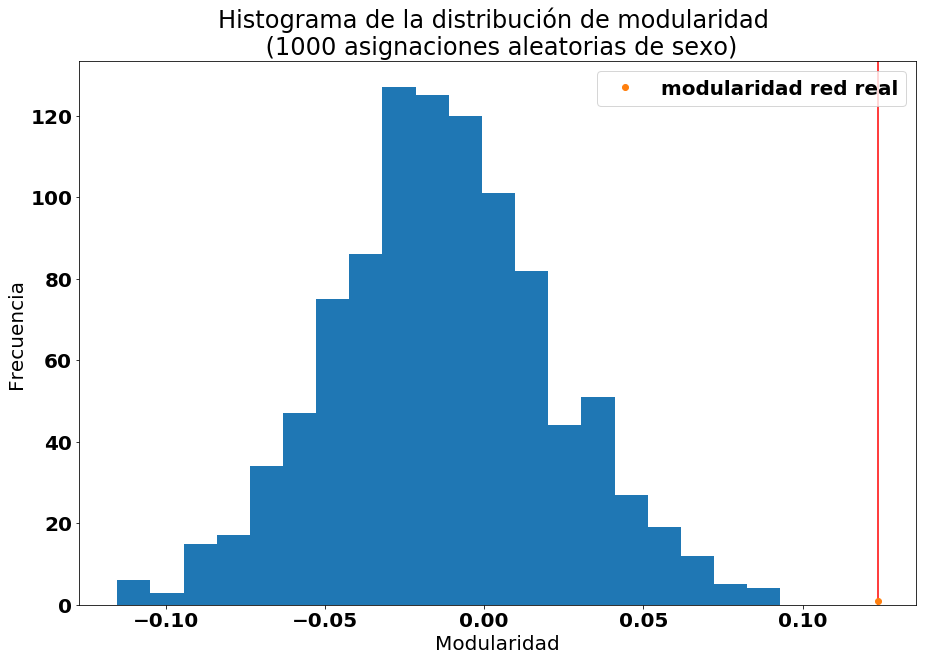

In [17]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)

plt.figure(figsize=(15,10))
plt.hist(DistributionModularity,bins=20)
plt.axvline(modularity(G, 'gender'), c="red")
plt.plot(modularity(G, 'gender'),1,'o',label='modularidad red real')
plt.title("Histograma de la distribución de modularidad \n (%i asignaciones aleatorias de sexo)" %it)
plt.xlabel("Modularidad")
plt.ylabel("Frecuencia")
plt.legend()
show()

# ii. A partir de lo obtenido proponga una estimación para el valor y el error de dicha cantidad cuando no existe vínculo entre topolgía de la red medio y asignación de género. Compare su estimación con el valor medio esperado.

In [18]:
np.mean(DistributionModularity), modularity(G, 'gender'), np.std(DistributionModularity)

(-0.013000395553973473, 0.12370950516197912, 0.03515009700942713)

Entonces, el valor que sale aleatorio es: $-0.013 \pm 0.035$ en unidades arbitrarias 
Y el valor real es 0.12 que se encuentra fuera del intervalo del valor medio de la distribucion aleatoria

# (iii) Estime la significancia estadística (p-valor) del valor observado en el caso de la red real.

In [19]:
#apariciones de valores por encima del que presenta nuestro grafo con la atribucion genero
frecuencia=sum(DistributionModularity>=modularity(G, 'gender'))

In [20]:
# p-value: area a derecha del valor real en el histograma
pvalue = (max(DistributionModularity) - modularity(G, 'gender')) * (frecuencia/it)
print('p-value:',pvalue)

pcrit=1/1000 #en general se toma ese valor 

if pvalue <= (pcrit):                                                          
    print("fuera de la hipotesis nula")
else:
    print ("en la hipotesis nula")

p-value: -0.0
fuera de la hipotesis nula
